<a href="https://colab.research.google.com/github/kumarmanishjha/pgm-prjoject_A18/blob/master/VAE_with_conv_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Reshape, AveragePooling2D, UpSampling2D

#MNIST
num_classes = 10

(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()
#(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

m = 100
n_epoch = 20

latent_dim= 2

#Use image and label as input together

# Q(z|X,y) -- encoder

pic_size = 32
channel = 3

inputs = Input(shape=(pic_size,pic_size,channel))

print(inputs.shape)


Using TensorFlow backend.


170500096/170498071 [==============================] - 30s 0us/step
(?, 32, 32, 3)


In [2]:
print(inputs.shape)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
print(x.shape)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = AveragePooling2D(pool_size=(2, 2))(x)
print(x.shape)
x = Dropout(0.2)(x)


x = Flatten()(x)
print(x.shape)

h = Dense(pic_size, activation='relu')(x)
print(h.shape)

(?, 32, 32, 3)
(?, 32, 32, 32)
(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 8, 8, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, ?)
(?, 32)


In [3]:
# calculate the mu and sigmas 
mu = Dense(latent_dim)(h)
print(mu.shape)
log_sigma = Dense(latent_dim)(h)
print(log_sigma.shape)

(?, 2)
(?, 2)


In [4]:

def sampling(args):
    mu, log_sigma = args
    epsilon = K.random_normal(shape=(m, 2))
    return mu + K.exp(log_sigma / 2) * epsilon
  
  
z = Lambda(sampling, output_shape=(2,))([mu, log_sigma])

print(z.shape)

(100, 2)


In [0]:
x = Dense(4*4*pic_size, activation='relu')(z)
print(x.shape)
x = Reshape((4,4,pic_size))(x)
print(x.shape)


x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

h_decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
print(h_decoded.shape)


In [0]:
#outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, h_decoded)

In [0]:
from keras import objectives
def vae_loss(inputs, h_decoded):
    xent_loss = K.mean(objectives.binary_crossentropy(inputs, h_decoded) *pic_size*pic_size*3)
    kl_loss = - 0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
    return xent_loss + kl_loss
  
vae.compile(optimizer='adam', loss=vae_loss)

In [0]:
vae.fit(x_train, x_train, batch_size = m, epochs = 20)

In [29]:
#Encoder Model
#encoder = Model(inputs, [mu, log_sigma, z])
encoder = Model(inputs, mu)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
__________

In [0]:
#decoder

latent_inputs = Input(shape=(latent_dim,))
print(latent_inputs.shape)

x = Dense(4*4*pic_size, activation='relu')(latent_inputs)
print(x.shape)
x = Reshape((4,4,pic_size))(x)
print(x.shape)


x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
print(x.shape)

x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
print(x.shape)

decoder = Model(latent_inputs, x)
decoder.summary()


In [0]:
n = 15
img_size = 32
img_chns = 3
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
add_path = '/content/drive/My Drive/Colab Notebooks/cifar_created_img/'

'''
for i in range(num_generated):
    img = pred[i,:].reshape(28,28)
    plt.imshow(img, cmap='Greys_r')
    plt.savefig(add_path+str(i)+'.png')
'''

epochs:  0
Losses 0


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/0_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/0_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/0_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/0_3.png is a low contrast image
  warn('%s is a low contra

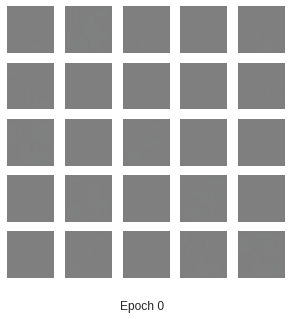

epochs:  1
Losses 1952.4938


/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/1_0.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/1_1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/1_2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/1_3.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: /content/drive/My Drive/Colab Notebooks/cifar_created_img/1_4.png is a low contrast i

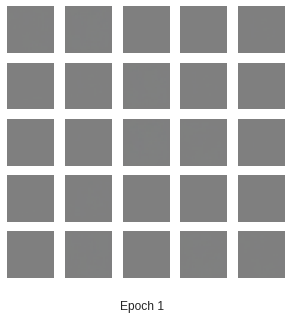

epochs:  2
Losses 1944.2766


In [0]:
#%% training
from skimage.io import imsave
import itertools
import os

add_path = '/content/drive/My Drive/Colab Notebooks/cifar_created_img/'

def save_batch_result(batch_data, path, epoch):
    batch_size = batch_data.shape[0]
    for i in range(batch_size):
        f_name = str(epoch) + '_' + str(i) + '.png'
        img_sav = batch_data[i]
        imsave(os.path.join(path,f_name), img_sav)

def show_result(batch_data, path, epoch, show):
      size_figure_grid = 5
      fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
      for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
          ax[i, j].get_xaxis().set_visible(False)
          ax[i, j].get_yaxis().set_visible(False)

      for k in range(5*5):
          i = k // 5
          j = k % 5
          ax[i, j].cla()
          ax[i, j].imshow(batch_data[k])

      label = 'Epoch {0}'.format(epoch)
      fig.text(0.5, 0.04, label, ha='center')
      plt.savefig(os.path.join(path , str(epoch)))

      if show:
          plt.show()
      else:
          plt.close()
          
def train_on_batch(x_batch, epoch):
    x_r = x_batch
    batchsize = x_r.shape[0]
    loss = vae.train_on_batch(x_r,x_r)
    return loss


#%%%
#%% Training 
n_epoch = 20  


size = x_train.shape[0]
loss = 0

for epoch in range(n_epoch):
    print ("epochs: ", epoch)
    print ("Losses", loss)
    for i in range(int(size/m)):
        idx = np.random.randint(0, x_train.shape[0], m)
        imgs = x_train[idx]
        loss = train_on_batch(imgs, epoch)
    #save input image
    save_batch_result(imgs[0:50], add_path, epoch)
    #save generated image
    f_latent = encoder.predict([imgs[0:50]])
    f_image = decoder.predict([f_latent])
    save_batch_result(f_image, add_path, epoch)
    show_result(f_image, add_path, epoch, True)


#%%
